In [45]:
#Using word lists from www.sketchengine.eu

from __future__ import unicode_literals,print_function,division
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)

print(findFiles('data/words/*.csv'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters) # the number or letters in the given ascii table (57 total letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='ANSI').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/words/*.csv'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)


['data/words\\english.csv', 'data/words\\french.csv', 'data/words\\german.csv', 'data/words\\italian.csv', 'data/words\\spanish.csv']
Slusarski


In [47]:
print(category_lines['english'][:5])

['the', 'and', 'to', 'of', 'a']


In [48]:
import torch 

# transforms a letter to a number "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

#Turn a string of letters into a tensor of size <word_length x 1 x n_letters>
def lineToTensor(line):
    tensor = torch.zeros(len(line),1,n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('ò'))
print(lineToTensor('Scòtt').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 1.]])
torch.Size([5, 1, 57])


In [49]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self,input_size,hidden_size,output_size):
        super(RNN,self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.LSTM(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden,_ = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [50]:
input = lineToTensor('se')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-1.5991, -1.6619, -1.5697, -1.6425, -1.5773]],
       grad_fn=<LogSoftmaxBackward0>)


In [51]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = italian / line = morte
category = english / line = few
category = german / line = einer
category = english / line = idea
category = german / line = ebenso
category = german / line = deutlich
category = french / line = soit
category = french / line = ce
category = french / line = aura
category = spanish / line = mundial


In [52]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('german', 2)


In [53]:
criterion = nn.NLLLoss()

In [54]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

In [55]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 10s) 1.7077 was / spanish ✗ (english)
10000 10% (0m 21s) 0.9727 hanno / italian ✓
15000 15% (0m 32s) 2.1217 siguiente / french ✗ (spanish)
20000 20% (0m 43s) 0.8394 natura / italian ✓
25000 25% (0m 54s) 0.5574 italiani / italian ✓
30000 30% (1m 4s) 0.8533 eigentlich / german ✓
35000 35% (1m 15s) 1.1454 marche / french ✓
40000 40% (1m 26s) 0.8648 linea / italian ✓
45000 45% (1m 37s) 0.9349 hacia / italian ✗ (spanish)
50000 50% (1m 47s) 0.9051 quelque / french ✓
55000 55% (1m 58s) 1.7358 occasion / spanish ✗ (french)
60000 60% (2m 9s) 0.9571 produits / french ✓
65000 65% (2m 20s) 0.5592 nAmlich / german ✓
70000 70% (2m 30s) 0.4857 hatten / german ✓
75000 75% (2m 41s) 0.4964 ancora / italian ✓
80000 80% (2m 52s) 1.7126 after / german ✗ (english)
85000 85% (3m 3s) 2.8618 blog / english ✗ (french)
90000 90% (3m 14s) 0.9598 still / english ✓
95000 95% (3m 25s) 0.7646 con / spanish ✓
100000 100% (3m 36s) 0.4521 dopo / italian ✓


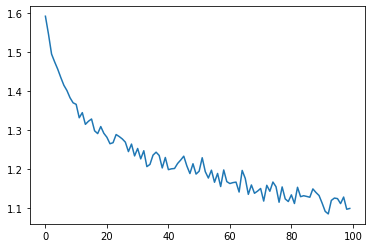

In [56]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

C:\Users\Scott Hamilton\AppData\Local\Temp\ipykernel_10916\3649271960.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
C:\Users\Scott Hamilton\AppData\Local\Temp\ipykernel_10916\3649271960.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


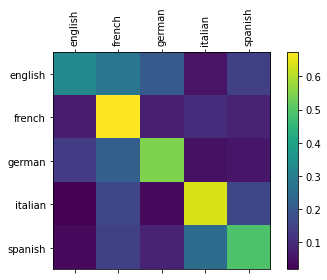

In [57]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()


In [58]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('oscura')
predict('baguette')
predict('mich')


> oscura
(-0.61) italian
(-1.08) spanish
(-2.59) french

> baguette
(-1.18) italian
(-1.19) french
(-1.84) english

> mich
(-0.56) german
(-1.10) english
(-3.20) french
